In [1]:
import pandas as pd
import numpy as np
import os

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import forestplot as fp # https://dev.to/lsys/making-coefficient-plots-in-python-using-forestplot-7i7
# from scipy.stats import pearsonr

import matplotlib as mpl
# plot by AHA 
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set_style("whitegrid")

import sys
sys.path.append('/Users/clu/git/3D_cardiac_GWAS/src')
from config import traits_dictionary
traits2names = {v: k for k, v in traits_dictionary.items()}
from transforms import rank_INT
from bullseye import bullseye_plot, get_cmap_center

from qvalue_python3 import qvalue_estimate


In [3]:
working_dir = '/Volumes/acasis/cardiac/48K/burden_aha_t64'

input_regenie = f'{working_dir}/burden_40kahat64_sexagebmibsa2bp_WT_t32_merged.regenie'
input_strain_regenie = f'{working_dir}/burden_40kahat64_sexagebmibsa2bp_E_t32_merged.regenie'

# read regional association results
wt = pd.read_csv(input_regenie, sep='\t')

strain = pd.read_csv(input_strain_regenie, sep='\t')

wt = wt[~wt.EXTRA.str.contains('WT_Max')]

def process_burden(df):
    # set AHA, trait and sort by AHA, locatios
    df=df.assign(trait=df.EXTRA.str.split('_').str[3], AHA=df.EXTRA.str.split('_').str[5].astype(int))
    df.drop(columns=['EXTRA', 'label'], inplace=True)
    df.sort_values(by=['AHA','CHROM','GENPOS'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    # set pvalue, qvalue
    df = df.assign(pvalue = 10**(-df.LOG10P))
    return df

wt = process_burden(wt)
strain = process_burden(strain)

# print types of ALLELE1, TEST
print(wt['ALLELE1'].unique())
print(wt['TEST'].unique())

['M1.singleton' 'M1.0.0001' 'M1.0.001' 'M1.0.01' 'M1.all' 'M3.singleton'
 'M3.0.0001' 'M3.0.001' 'M3.0.01' 'M3.all']
['ADD' 'ADD-ACATO' 'ADD-ACATV' 'ADD-SKAT' 'ADD-SKATO' 'ADD-SKATO-ACAT']


In [47]:
def set_qvalue(df):
    df = df.assign(qvalue = qvalue_estimate(df.pvalue))
    return df

wt = wt.assign(qvalue = np.nan)
strain = strain.assign(qvalue = np.nan)
with open('qvalue_summary.txt', 'w') as f:
    for test in wt['TEST'].unique():
        for allele in wt['ALLELE1'].unique():
            try:
                df = set_qvalue(wt[(wt.ALLELE1==allele) & (wt.TEST==test) ])
            except Exception as e:
                # print('wt:', test, allele, e)
                continue
            df = set_qvalue(wt[(wt.ALLELE1==allele) & (wt.TEST==test) ])
            wt.loc[(wt.ALLELE1==allele) & (wt.TEST==test), 'qvalue'] = df.qvalue
            print('wt:', test, allele, df.shape[0], df['ID'].nunique(), sum(df.qvalue<0.05), ','.join([x.split('(')[0] for x in df[df.qvalue<0.05].ID]), file=f, flush=True)
            dfs = strain[(strain.ALLELE1==allele) & (strain.TEST==test) ]
            strain.loc[(strain.ALLELE1==allele) & (strain.TEST==test), 'qvalue'] = set_qvalue(dfs).qvalue
            dfs1 = set_qvalue(dfs[dfs.trait=='Ecc'])
            print('Ecc:', test, allele, dfs1.shape[0], dfs1['ID'].nunique(), sum(dfs1.qvalue<0.05), ','.join([x.split('(')[0] for x in dfs1[dfs1.qvalue<0.05].ID]), file=f, flush=True)
            dfs2 = set_qvalue(dfs[dfs.trait=='Err'])
            print('Err:', test, allele,dfs2.shape[0], dfs2['ID'].nunique(), sum(dfs2.qvalue<0.05), ','.join([x.split('(')[0] for x in dfs2[dfs2.qvalue<0.05].ID]), file=f, flush=True)


In [48]:
# save pickle wt and strain for further analysis
wt.to_pickle('wt.pkl')
strain.to_pickle('strain.pkl')

# Supplementary Table for M1 and M3 scores


127 1134
111 1260
104 1293
31 371
40 412
42 418


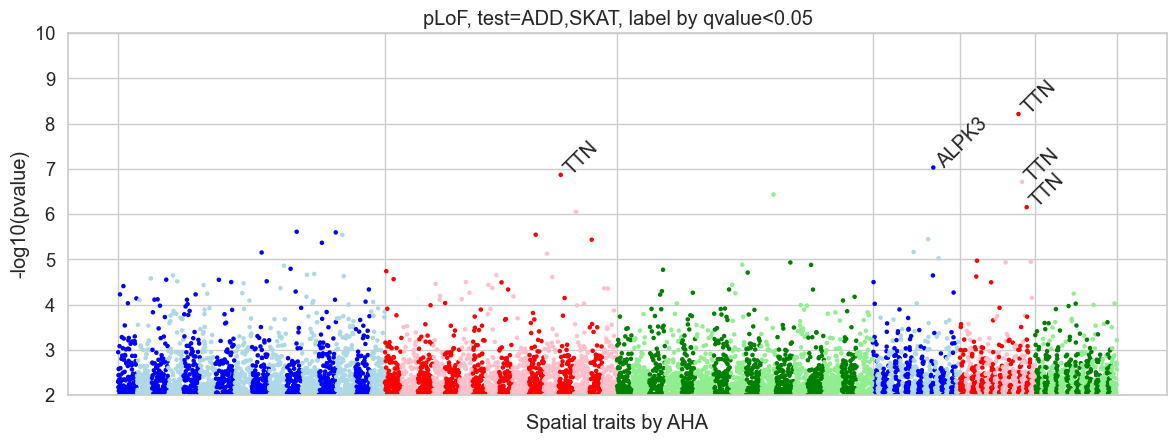

In [51]:
# manhattan plot only for pvalue<0.01, significance level qvalue<0.05
wt2 = wt[wt.pvalue<0.01]
strain2 = strain[strain.pvalue<0.01]

lengths = []
def getplots(wt):
    toplot=wt[(wt.ALLELE1=='M1.all') & (wt.TEST=='ADD')]
    # group by ID and AHA and keep the row with the smallest pvalue
    # toplot = toplot.groupby(['ID','AHA']).apply(lambda x: x[x.pvalue==x.pvalue.min()]).reset_index(drop=True)
    # order by AHA and reindex by order given in CHR, GENPOS
    toplot = toplot.sort_values(by=['AHA','CHROM','GENPOS'])
    print(toplot[toplot.AHA==1].shape[0], toplot.ID.nunique())
    lengths.append(toplot.shape[0])
    return toplot

toplot = getplots(wt2)
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Ecc'])])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Err'])])

def getplots(wt):
    toplot=wt[(wt.ALLELE1=='M1.all') & (wt.TEST=='ADD-SKAT')]
    # group by ID and AHA and keep the row with the smallest pvalue
    # toplot = toplot.groupby(['ID','AHA']).apply(lambda x: x[x.pvalue==x.pvalue.min()]).reset_index(drop=True)
    # order by AHA and reindex by order given in CHR, GENPOS
    toplot = toplot.sort_values(by=['AHA','CHROM','GENPOS'])
    print(toplot[toplot.AHA==1].shape[0], toplot.ID.nunique())
    lengths.append(toplot.shape[0])
    return toplot

toplot = pd.concat([toplot, getplots(wt2)])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Ecc'])])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Err'])])

# set seaborn font Arial and size 12
sns.set(font='Arial', font_scale=1.2)
# background color white
sns.set_style("whitegrid")
# plot LOG10P by AHA, and GENPOS
plt.figure(figsize=(12, 4.5))
# set x as rank
toplot = toplot.assign(x = range(toplot.shape[0]))
# set x ticks as cumulative sum of lengths
xticks = np.cumsum([0]+lengths)
# color by AHA odd and even
toplot = toplot.assign(color = toplot.AHA%2)
# plot trait WT as dark blue, strain as light blue
cmap = mpl.colors.ListedColormap(['lightblue', 'blue'])
plt.scatter(x=toplot[toplot.trait=='WT'].x, y=toplot[toplot.trait=='WT'].LOG10P, c=toplot[toplot.trait=='WT'].color, cmap=cmap, s=5)
# plot trait Ecc as dark red, Err as light red
cmap = mpl.colors.ListedColormap(['pink', 'red'])
plt.scatter(x=toplot[toplot.trait=='Ecc'].x, y=toplot[toplot.trait=='Ecc'].LOG10P, c=toplot[toplot.trait=='Ecc'].color, cmap=cmap, s=5)
# plot trait Err as dark green, Ecc as light green
cmap = mpl.colors.ListedColormap(['lightgreen', 'green'])
plt.scatter(x=toplot[toplot.trait=='Err'].x, y=toplot[toplot.trait=='Err'].LOG10P, c=toplot[toplot.trait=='Err'].color, cmap=cmap, s=5)
plt.xlabel('Spatial traits by AHA')
plt.ylabel('-log10(pvalue)')
# add AHA as xticks
# ticks are set at the ends of each trait
plt.xticks(ticks=xticks)
# xtick labels off
plt.gca().set_xticklabels([])
# label by ID for qvalue<0.05
for i, row in toplot[toplot.qvalue<0.05].iterrows():
    plt.text(row.x, row.LOG10P, row.ID.split('(')[0], rotation=45)
# y axis limit
plt.ylim(2, 10)
plt.tight_layout()
# title
plt.title('pLoF, test=ADD,SKAT, label by qvalue<0.05')
# save figure as pdf
plt.savefig('M1.ADD_SKAT.pdf')

190 1697
153 2082
150 1917
55 501
54 620
48 547


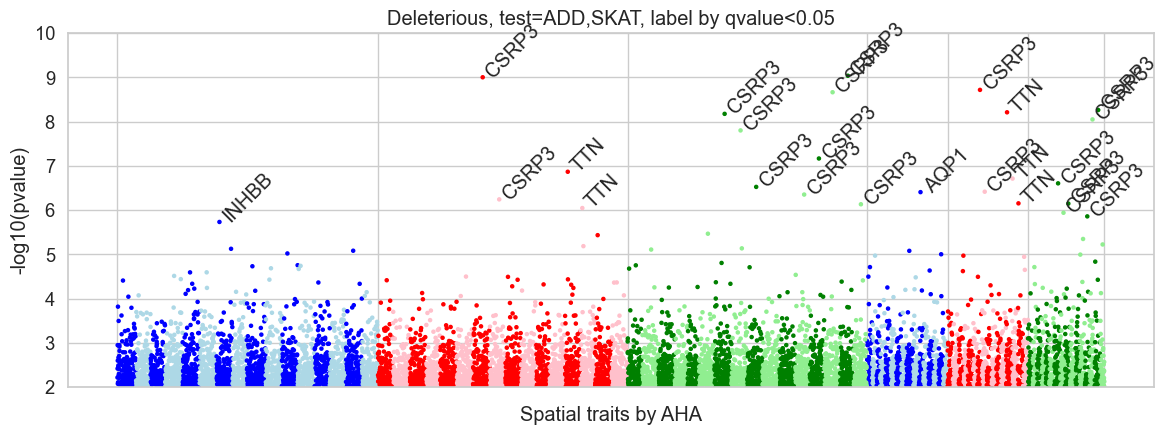

In [53]:
lengths = []
def getplots(wt):
    toplot=wt[(wt.ALLELE1=='M3.all') & (wt.TEST=='ADD')]
    # keep genes with A1FREQ<0.05
    keepgenes = set(wt[wt.A1FREQ<0.05].ID.unique())
    toplot = toplot[toplot.ID.isin(keepgenes)]
    # sort by AHA, locatios
    toplot = toplot.sort_values(by=['AHA','CHROM','GENPOS'])
    print(toplot[toplot.AHA==1].shape[0], toplot.ID.nunique())
    lengths.append(toplot.shape[0])
    return toplot

toplot = getplots(wt2)
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Ecc'])])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Err'])])

def getplots(wt):
    toplot=wt[(wt.ALLELE1=='M3.all') & (wt.TEST=='ADD-SKAT')]
    # keep genes with A1FREQ<0.05
    keepgenes = set(wt[wt.A1FREQ<0.05].ID.unique())
    toplot = toplot[toplot.ID.isin(keepgenes)]
    # group by ID and AHA and keep the row with the smallest pvalue
    # toplot = toplot.groupby(['ID','AHA']).apply(lambda x: x[x.pvalue==x.pvalue.min()]).reset_index(drop=True)
    # order by AHA and reindex by order given in CHR, GENPOS
    toplot = toplot.sort_values(by=['AHA','CHROM','GENPOS'])
    print(toplot[toplot.AHA==1].shape[0], toplot.ID.nunique())
    lengths.append(toplot.shape[0])
    return toplot

toplot = pd.concat([toplot, getplots(wt2)])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Ecc'])])
toplot = pd.concat([toplot, getplots(strain2[strain2.trait=='Err'])])

# keepgenes = set(toplot[toplot.A1FREQ<0.05].ID.unique())
# print('keep:', len(keepgenes), 'remove:', toplot.ID.nunique()-len(keepgenes))
# toplot = toplot[toplot.ID.isin(keepgenes)]

# set seaborn font Arial and size 12
sns.set(font='Arial', font_scale=1.2)
# background color white
sns.set_style("whitegrid")
# plot LOG10P by AHA, and GENPOS
plt.figure(figsize=(12, 4.5))
# set x as rank
toplot = toplot.assign(x = range(toplot.shape[0]))
# set x ticks as cumulative sum of lengths
xticks = np.cumsum([0]+lengths)
# color by AHA odd and even
toplot = toplot.assign(color = toplot.AHA%2)
# plot trait WT as dark blue, strain as light blue
cmap = mpl.colors.ListedColormap(['lightblue', 'blue'])
plt.scatter(x=toplot[toplot.trait=='WT'].x, y=toplot[toplot.trait=='WT'].LOG10P, c=toplot[toplot.trait=='WT'].color, cmap=cmap, s=5)
# plot trait Ecc as dark red, Err as light red
cmap = mpl.colors.ListedColormap(['pink', 'red'])
plt.scatter(x=toplot[toplot.trait=='Ecc'].x, y=toplot[toplot.trait=='Ecc'].LOG10P, c=toplot[toplot.trait=='Ecc'].color, cmap=cmap, s=5)
# plot trait Err as dark green, Ecc as light green
cmap = mpl.colors.ListedColormap(['lightgreen', 'green'])
plt.scatter(x=toplot[toplot.trait=='Err'].x, y=toplot[toplot.trait=='Err'].LOG10P, c=toplot[toplot.trait=='Err'].color, cmap=cmap, s=5)
plt.xlabel('Spatial traits by AHA')
plt.ylabel('-log10(pvalue)')
# add AHA as xticks
# ticks are set at the ends of each trait
plt.xticks(ticks=xticks)
plt.gca().set_xticklabels([])
# label by ID for qvalue<0.05
for i, row in toplot[toplot.qvalue<0.05].iterrows():
    plt.text(row.x, row.LOG10P, row.ID.split('(')[0], rotation=45)
# y axis limit
plt.ylim(2, 10)
plt.tight_layout()
# title
plt.title('Deleterious, test=ADD,SKAT, label by qvalue<0.05')
# save figure as pdf
plt.savefig('M3.ADD_SKAT.pdf')

# Summary of M1 and M3 unique genes


In [37]:
print('wt,M1:', ', '.join([x.split('(')[0] for x in wt[(wt.qvalue<0.05) & (wt.ALLELE1.str.startswith('M1'))].ID.unique()]))
print('strain,M1:', ', '.join([x.split('(')[0] for x in strain[(strain.qvalue<0.05) & (strain.ALLELE1.str.startswith('M1'))].ID.unique()]))

wt,M1: ALPK3
strain,M1: TTN, CDH2, TTN, TTN, TTN, TTN


In [38]:
print('wt,M3:', ', '.join([x.split('(')[0] for x in wt[(wt.qvalue<0.05) & (wt.ALLELE1.str.startswith('M3'))].ID.unique()]))
print('strain,M3:', ', '.join([x.split('(')[0] for x in strain[(strain.qvalue<0.05) & (strain.ALLELE1.str.startswith('M3'))].ID.unique()]))

wt,M3: ADPRHL1, INHBB, KANSL1, AQP1
strain,M3: CSRP3, TTN, CSRP3, CDH2, TTN, TTN, TTN
